In [59]:
# import all libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
#from statsmodels.multivariate.pca import  PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [42]:
train = pd.read_csv('data/train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [53]:
def df_clean_up(dirty_df):
    """
    Takes dirty testing or training dataframe and cleans up for statistical analysis.
    return clean dataframe :-)
    """
    # Replace string grades with numbers for analysis using same scale as Overall Quality/Condition
    # Affects ExterQual, ExterCond,BsmtQual, BsmtCond, HeatingQC, KitchenQual, FirePlace, GarageQual/Cond, Pool Quality
    # Ex = Excellent = 9
    # Gd = Good = 7
    # TA = Average/Typical = 5
    # Fa = Fair = 3
    # Po = Poor = 2
    # NA = -1  
    dirty_df.replace(['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'], [9, 7, 5, 3, 2, -1], inplace = True)

    # convert 0 to np.nan since 0 is not an indicator for anything
    dirty_df.replace(0, np.nan, inplace = True)
   
    # check empty columns/data
    #null_array = dirty_df.isnull().sum()
    #null_array = null_array[null_array > 0]
    
    # drop by threshold (minimum valid 50%)
    dirty_df.dropna(axis = 'columns', thresh = int(dirty_df.shape[0]*.5), inplace = True) 

    # Set 'Id' as Index
    dirty_df.set_index(['Id'], inplace = True)
    
    # drop rows missing a lot of data
    dirty_df.dropna(thresh = 60, inplace = True)

    # I think that YrSold and YearBuilt are important so I'm dropping any row that doesn't have them
    dirty_df.dropna(subset=['YrSold', 'YearBuilt'], inplace = True)
    
    # replace zeros back
    dirty_df.fillna(0, inplace = True)
    
    return dirty_df #actually clean df


In [44]:
clean_train = df_clean_up(train)

In [45]:
train_numeric_values = clean_train.select_dtypes(include = 'number')
train_numeric_values.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtQual,...,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,GarageQual,GarageCond,OpenPorchSF,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,7,5,7.0,...,0.0,2003.0,2.0,548.0,5.0,5.0,61.0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,5,5,7.0,...,5.0,1976.0,2.0,460.0,5.0,5.0,0.0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,7,5,7.0,...,5.0,2001.0,2.0,608.0,5.0,5.0,42.0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,5,5,5.0,...,7.0,1998.0,3.0,642.0,5.0,5.0,35.0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,7,5,7.0,...,5.0,2000.0,3.0,836.0,5.0,5.0,84.0,12,2008,250000


In [46]:
train_numeric_values.corr()['SalePrice'].sort_values(ascending = False)

SalePrice       1.000000
OverallQual     0.776806
GrLivArea       0.699616
ExterQual       0.666072
GarageCars      0.649928
KitchenQual     0.643539
BsmtQual        0.629691
GarageArea      0.609473
TotalBsmtSF     0.583843
1stFlrSF        0.583640
FullBath        0.555132
TotRmsAbvGrd    0.546300
YearRemodAdd    0.486521
YearBuilt       0.473131
GarageYrBlt     0.460035
FireplaceQu     0.444027
HeatingQC       0.400526
Fireplaces      0.382486
BsmtFinSF1      0.335162
OpenPorchSF     0.276236
LotArea         0.247229
BsmtUnfSF       0.210122
LotFrontage     0.199837
BedroomAbvGr    0.146087
BsmtCond        0.128966
GarageQual      0.113150
GarageCond      0.084462
MoSold          0.043854
YrSold         -0.014085
ExterCond      -0.021087
KitchenAbvGr   -0.104808
MSSubClass     -0.105587
OverallCond    -0.122286
Name: SalePrice, dtype: float64

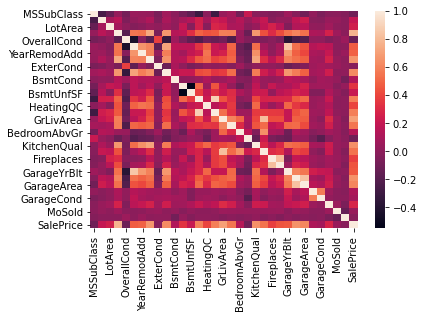

In [47]:
sns.heatmap(train_numeric_values.corr())

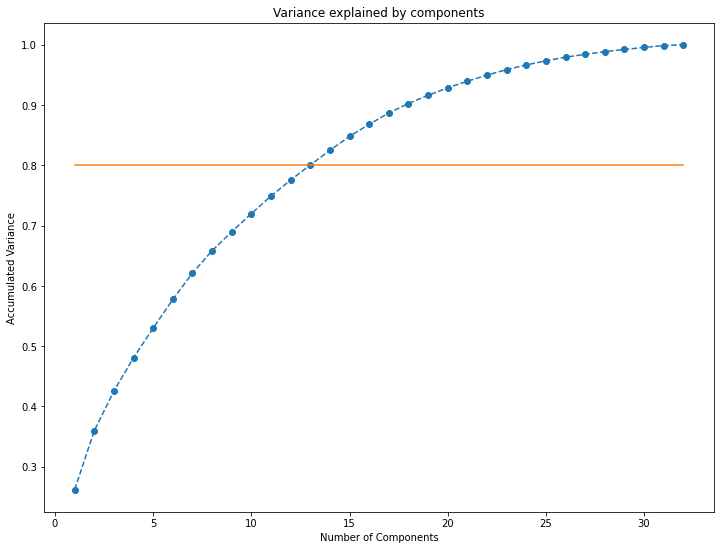

In [49]:
# We will use the numeric components to predict the Sale Price
X_train = train_numeric_values.drop('SalePrice', 1)
y_train = train_numeric_values['SalePrice']

pca = PCA()

# PCA works better wehn the data is scaled.
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_train = pca.fit_transform(X_train)

plt.figure(figsize=(12,9))
plt.plot(range(1,33), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle="--")
plt.plot(range(1,33), [.8]*32)
plt.title("Variance explained by components")
plt.xlabel("Number of Components")
plt.ylabel("Accumulated Variance"); #Golden Rule is greater than 80%

# 14 appears to be exactly 80% so a better number would be 15


In [50]:
X_train = train_numeric_values.drop('SalePrice', 1)
y_train = train_numeric_values['SalePrice']
pca = PCA(n_components= 15)
sc = StandardScaler()
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_train = pca.fit_transform(X_train)

df_pca_comp = pd.DataFrame(data= pca.components_,
                           columns = numeric_values.drop('SalePrice', 1).columns.values,
                           index = [f'Principal Component {i}' for i in range(1,16)]
                           )

df_pca_comp

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtQual,...,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,GarageQual,GarageCond,OpenPorchSF,MoSold,YrSold
Principal Component 1,-0.017900,0.074416,0.060408,0.291026,-0.106641,0.245617,0.232556,0.276007,-0.025915,0.268683,...,0.111612,0.147769,0.249105,0.270955,0.253939,0.054380,0.047914,0.119285,0.015871,-0.004075
Principal Component 2,-0.123905,0.129076,0.221628,-0.003943,0.104056,-0.298989,-0.228503,-0.104997,0.070635,-0.159382,...,0.293341,0.236724,-0.296906,0.003512,0.031115,-0.078907,-0.100173,0.042386,0.042217,-0.023122
Principal Component 3,-0.245508,0.029044,0.185583,-0.025134,0.072196,0.000940,-0.044887,-0.023920,0.075896,0.006440,...,0.181081,0.109129,-0.041928,-0.044745,0.053262,0.169382,0.204820,-0.046942,-0.055349,0.054040
Principal Component 4,0.140671,-0.207780,-0.021546,0.071059,0.375899,-0.055478,0.116719,0.024563,0.376169,-0.033423,...,0.198510,0.181254,-0.010710,-0.069633,-0.087043,0.357393,0.364844,0.084731,0.059166,-0.031740
Principal Component 5,-0.435294,0.345390,-0.004940,-0.078741,0.207383,-0.048429,0.049228,-0.045056,0.246518,-0.112091,...,-0.392761,-0.372418,0.025991,0.033608,0.128475,0.186749,0.238541,0.079627,-0.003414,0.013323
Principal Component 6,0.249586,-0.014497,0.065525,-0.097247,-0.234899,0.078507,-0.117895,-0.137808,-0.143366,0.010053,...,-0.168296,-0.256374,0.136843,0.119070,0.167393,0.348926,0.285490,0.016102,-0.032558,-0.045418
Principal Component 7,-0.125606,-0.027973,-0.015884,0.008753,-0.325131,0.053669,-0.178810,-0.068779,-0.305888,-0.019703,...,0.203844,0.251836,0.050927,-0.014872,-0.028141,0.344626,0.359494,-0.142677,0.010574,-0.116154
Principal Component 8,0.025036,0.028315,0.004642,-0.007267,-0.070586,0.005785,-0.084374,-0.015528,0.059190,0.007313,...,-0.015264,0.001088,-0.008015,0.050875,0.046584,-0.046084,-0.044079,0.178886,0.573058,-0.673101
Principal Component 9,0.290320,-0.316714,-0.195954,0.006090,0.113283,-0.133874,-0.003669,0.028419,0.252650,-0.069409,...,-0.003402,0.000028,-0.044839,0.035391,0.081526,0.193742,0.037772,0.130399,0.000482,0.104945
Principal Component 10,-0.043338,0.008490,-0.070774,0.034855,-0.025996,-0.038359,0.059984,0.086305,-0.024391,-0.024812,...,-0.060772,-0.072050,-0.040578,-0.115964,-0.071177,0.045257,0.003421,0.327071,0.462041,0.026527


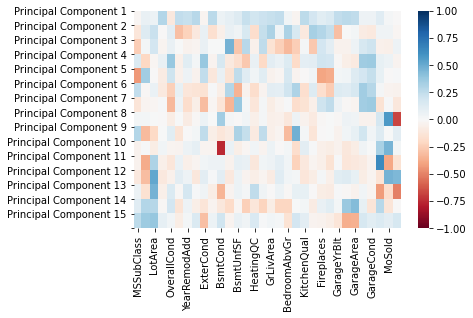

In [51]:
sns.heatmap(df_pca_comp,
            vmin = -1,
            vmax = 1,
            cmap='RdBu',
            annot=False
            )
plt.yticks(list(range(16)),
           [f'Principal Component {i}' for i in range(1,16)]
           );

In [57]:
test = pd.read_csv('data/test.csv')
test.head()
#test doesn't have a "SalePrice" column, so restructuring train/test from original dataset
X = train_numeric_values.drop('SalePrice', 1)
y = train_numeric_values['SalePrice']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [61]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

pca = PCA(n_components = 15)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [64]:
classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(f'Accuracy {accuracy_score(y_test, y_pred)}')

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Accuracy 0.016877637130801686
